# cardekho.com 

## SETUP

In [8]:
#Import standard libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, MaxAbsScaler,RobustScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import boxcox
from scipy.stats.mstats import normaltest
pd.set_option("display.max_rows",None)

from google.cloud import bigquery

# READ DATA

###Authenticate bigquery

In [4]:
# Install the Google Cloud BigQuery library
!pip install --user google-cloud-bigquery==1.25.0

     |████████████████████████████████| 169 kB 7.3 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 1.42.0 requires google-resumable-media<3.0dev,>=1.3.0; python_version >= "3.6", but you have google-resumable-media 0.5.1 which is incompatible.


### Pull the dataframe from bigquery

In [36]:
%%bigquery df
# SQL query to get a fields from dataset which prints the 10 records
SELECT 
    *
# TODO 3
FROM
    `linear_regression.car_dekho`



Downloading: 100%|██████████| 4340/4340 [00:01<00:00, 4316.18rows/s]


# EXPLORE AND CLEAN DATA


In [38]:
df.shape

(4340, 8)

In [39]:
# Make a copy of the original
data = df.copy()

#data = data[data.year>2015]
# The first word in the name columns looks like the manufacturer of the car.
# Since, we are not provided with this information in a separate column, we can
# extract it from the "name" column.
data["manufacturer"] = data.name.str.split(n=1,expand=True)[0]
data = data.drop("name",axis=1)

### EDA

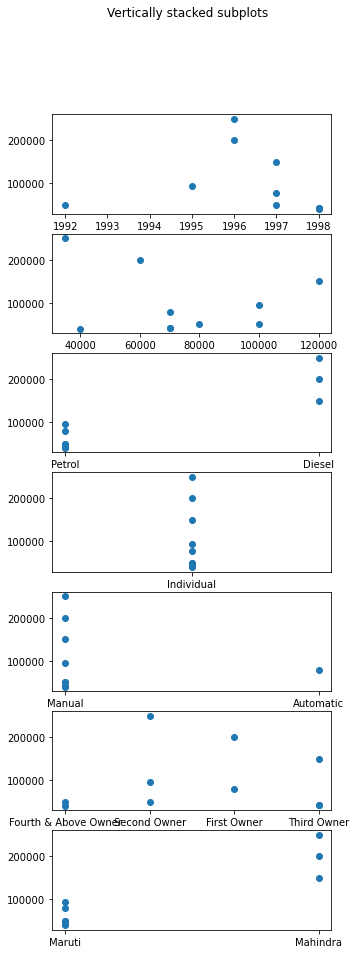

In [19]:
re_arrange_cols = ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'manufacturer', 'selling_price']

data = data[re_arrange_cols]

fig, (ax1, ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7)
fig.suptitle('Vertically stacked subplots')
fig.set_figheight(15)
fig.set_figwidth(5)
ax1.scatter(data.year, data.selling_price)
ax2.scatter(data.km_driven, data.selling_price)
ax3.scatter(data.fuel, data.selling_price)
ax4.scatter(data.seller_type, data.selling_price)
ax5.scatter(data.transmission, data.selling_price)
ax6.scatter(data.owner, data.selling_price)
ax7.scatter(data.manufacturer, data.selling_price)



(array([7., 0., 0., 0., 0., 0., 0., 0., 0., 3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

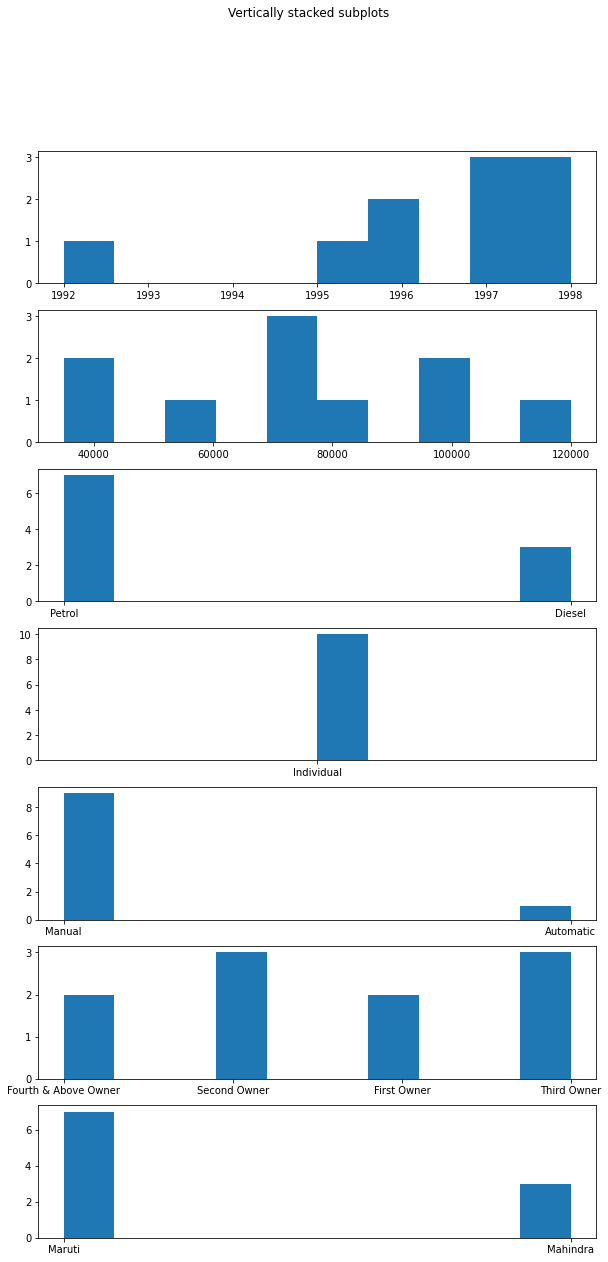

In [20]:
re_arrange_cols = ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'manufacturer', 'selling_price']

data = data[re_arrange_cols]

fig, (ax1, ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7)
fig.suptitle('Vertically stacked subplots')
fig.set_figheight(20)
fig.set_figwidth(10)
ax1.hist(data.year)
ax2.hist(data.km_driven)
ax3.hist(data.fuel)
ax4.hist(data.seller_type)
ax5.hist(data.transmission)
ax6.hist(data.owner)
ax7.hist(data.manufacturer)

In [21]:
# Select just the rows desired from the 'describe' method and add in the 'median'
#Check the min,max, mean,median,range and iqr for the numeric fields
stats_df = data.describe()
stats_df.loc['range'] = stats_df.loc['max'] - stats_df.loc['min']

out_fields = ['min','max','mean','25%','50%','75%','range']
stats_df = stats_df.loc[out_fields]

stats_df.rename({'50%':'median','25%':'q25','75%':'q75'},inplace=True)

stats_df.loc['iqr'] = stats_df.loc['q75'] - stats_df.loc['q25']

stats_df.T

# year: range shows that our data is spread over 28 years, staring from
# 1992 and ending in 2020. 
# Selling price range from 20000 to 89000000
#km driven range frmo 1 to 806599 

,min,max,mean,q25,median,q75,range,iqr
year,1992.0,1998.0,1996.4,1996.0,1997.0,1997.75,6.0,1.75
km_driven,35000.0,120000.0,74500.0,62500.0,70000.0,95000.00,85000.0,32500.00
selling_price,40000.0,250000.0,99800.0,44000.0,64500.0,136250.00,210000.0,92250.00


In [ ]:
#applying multiple functions at once - 2 methods
data.groupby('transmission').agg(['mean','median'])
#Shows Automatic cars sells for more and also newer


year            km_driven        selling_price         
                     mean median          mean median          mean   median
transmission                                                                
Automatic     2015.895939   2017  44462.824873  38500  1.526170e+06  1100000
Manual        2014.857143   2015  60548.743961  52600  4.792861e+05   425000

In [ ]:
data.groupby('manufacturer').agg('mean','median')

,year,km_driven,selling_price
manufacturer,,,
Ambassador,2012.000000,50000.000000,4.300000e+05
Audi,2014.018182,63937.872727,2.014509e+06
BMW,2016.314286,43869.828571,3.174000e+06
Chevrolet,2013.198582,67986.418440,2.622482e+05
Datsun,2016.513514,29564.351351,2.970269e+05
Fiat,2014.090909,74792.636364,3.670909e+05
Force,2014.000000,37516.000000,3.460000e+05
Ford,2015.307692,58595.671795,6.581538e+05
Honda,2015.527094,50184.349754,6.113300e+05


# FEATURE ENGINEERING

###Explore Target

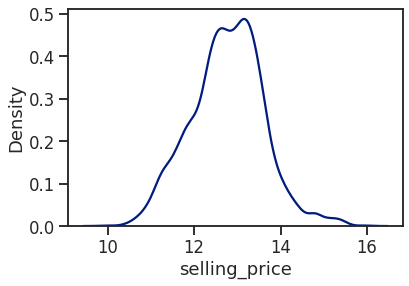

In [ ]:
sns.kdeplot(np.log(df.selling_price))

In [22]:
normaltest(np.log(df.selling_price))

/opt/conda/lib/python3.7/site-packages/scipy/stats/mstats_basic.py:2599: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  np.min(n))


NormaltestResult(statistic=1.9828132735653923, pvalue=0.3710543850144034)

<AxesSubplot:ylabel='Density'>

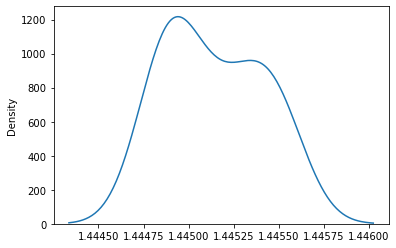

In [23]:
#test boxcox
target_boxcox = boxcox(df.selling_price)
sns.kdeplot(target_boxcox[0])

###Set up prediction

In [40]:
#Create subset of data for prediction
all_cols = ['year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'manufacturer']
sub_cols = [ 'year','km_driven','manufacturer','transmission','fuel','seller_type', 'selling_price']
small_data = data[sub_cols]
small_data.selling_price = boxcox(small_data.selling_price)[0]


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
# Do the one hot encoding
# Lets find the colms which need one hot encoding
ohc_cols = small_data.columns[small_data.dtypes == "object"]
print(ohc_cols)
# Determine how many extra columns would be created
num_ohc_cols = (small_data[ohc_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))
# Copy of the data
data_ohc = small_data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    print(col)
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(np.int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)


Index(['manufacturer', 'transmission', 'fuel', 'seller_type'], dtype='object')
manufacturer
fuel
seller_type
transmission


# FIT AND PREDICT

###Split the data with KFold

In [42]:
X = data_ohc.drop('selling_price', axis = 1)
y = data_ohc.selling_price


In [43]:
kf = KFold(shuffle=True, random_state=72018,n_splits=3)

In [44]:
for train_index,test_index in kf.split(X):
  print("Train index:",train_index[:10],len(train_index))
  print("Test index:", test_index[:10],len(test_index))
  print('')

Train index: [ 0  2  3  4  5  7  8  9 10 11] 2893
Test index: [ 1  6 14 15 17 18 20 22 26 30] 1447

Train index: [ 0  1  2  4  6  7  8 10 11 12] 2893
Test index: [ 3  5  9 16 19 21 23 24 27 31] 1447

Train index: [ 1  3  5  6  9 14 15 16 17 18] 2894
Test index: [ 0  2  4  7  8 10 11 12 13 25] 1446



###Define pipeline

In [45]:
s = StandardScaler()
r = RobustScaler()
lr = LinearRegression()
mi = MinMaxScaler()
max = MaxAbsScaler()

#estimator = Pipeline([("scaler",max), ("regression",lr)])
estimator = Pipeline([("regression",lr)])

###Get predictions

In [46]:
predictions = cross_val_predict(estimator,X,y, cv=kf)

In [48]:
y_series = pd.Series(y)
p_series = pd.Series(predictions)
frame = { 'y': y, 'p': predictions }

pd.DataFrame(frame).head(5)



,y,p
0,9.639541,8.938211
1,10.143125,9.207060
2,10.718447,9.845965
3,10.889089,9.888456
4,9.639541,9.397384


In [49]:
r2_score(y,predictions)

0.7887600127658596

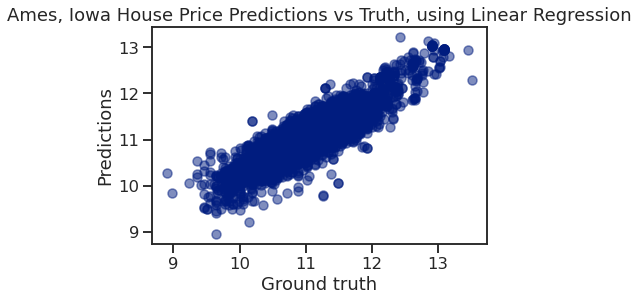

In [50]:

sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y, predictions, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Ames, Iowa House Price Predictions vs Truth, using Linear Regression');

##Tune Hyperparameters

In [33]:
alphas = np.geomspace(1e-9, 1e0, num=10)